In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
tasks = {
    'binary': [0, 1], 
    'type': [0, 1, 2, 3]
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'naive-bayes-multinomial']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [6]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [7]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications):
    df = pd.read_csv(f'{task}_predictions.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')

In [10]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications):
    df = pd.read_csv(f'{task}_predictions.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n\n\n')

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.


Task: Binary

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


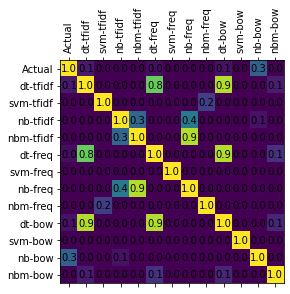

            Score 0   Score 1  Mean score
Actual     1.000000  1.000000    1.000000
dt-freq    0.848174  0.488372    0.668273
dt-tfidf   0.839041  0.482558    0.660800
svm-bow    0.921233  0.398256    0.659744
nbm-bow    0.855023  0.418605    0.636814
dt-bow     0.827626  0.444767    0.636197
svm-freq   0.965753  0.235465    0.600609
nbm-tfidf  0.696347  0.462209    0.579278
nb-bow     0.730594  0.375000    0.552797
nb-freq    0.676941  0.404070    0.540505
nb-tfidf   0.688356  0.383721    0.536039
svm-tfidf  0.992009  0.058140    0.525074
nbm-freq   1.000000  0.000000    0.500000

Mean: 0.6227791800426398



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 3.1171866709564227e-29
Post-hoc Dunn test array:


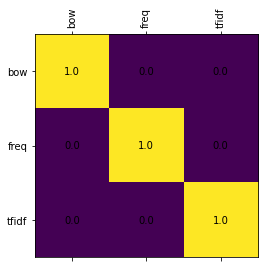

Scores: 
        Score 0   Score 1  Mean score
bow    0.938356  0.331395    0.634876
tfidf  0.963470  0.177326    0.570398
freq   0.984018  0.104651    0.544335

Mean: 0.5832028069802839





Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'naive-bayes-multinomial'].
Cochran's Q test p-value: 6.424514801420024e-33
Post-hoc Dunn test array:


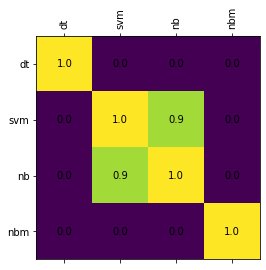

Scores: 
      Score 0   Score 1  Mean score
dt   0.856164  0.476744    0.666454
nbm  0.891553  0.311047    0.601300
svm  0.965753  0.223837    0.594795
nb   0.884703  0.255814    0.570259

Mean: 0.6082019220558565






Task: Type

Task: type.
Cochran's Q test p-value: 9.507160540844897e-85
Post-hoc Dunn test array:


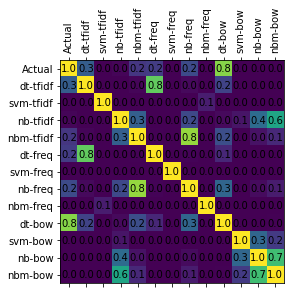

            Score 0  Score 1  Score 2   Score 3  Mean score
Actual     1.000000    1.000    1.000  1.000000    1.000000
dt-freq    0.627219    0.250    0.450  0.569106    0.474081
dt-tfidf   0.650888    0.125    0.450  0.577236    0.450781
dt-bow     0.650888    0.250    0.400  0.479675    0.445141
nbm-tfidf  0.739645    0.000    0.300  0.577236    0.404220
nb-freq    0.650888    0.000    0.300  0.495935    0.361706
nbm-bow    0.828402    0.000    0.100  0.479675    0.352019
nb-bow     0.721893    0.000    0.225  0.430894    0.344447
svm-bow    0.887574    0.000    0.000  0.422764    0.327585
nb-tfidf   0.680473    0.000    0.175  0.439024    0.323624
svm-freq   0.917160    0.000    0.000  0.276423    0.298396
svm-tfidf  0.964497    0.000    0.000  0.081301    0.261449
nbm-freq   0.994083    0.000    0.000  0.000000    0.248521

Mean: 0.4070745723103567



Task: type. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 8.669655250348989e-15
Post-hoc Dunn test array:


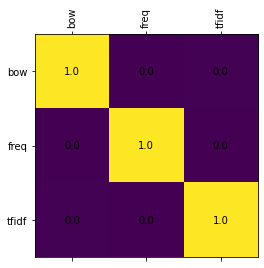

Scores: 
        Score 0  Score 1  Score 2   Score 3  Mean score
bow    0.893491      0.0    0.125  0.390244    0.352184
tfidf  0.905325      0.0    0.175  0.292683    0.343252
freq   0.964497      0.0    0.125  0.146341    0.308960

Mean: 0.33479849184586524





Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'naive-bayes-multinomial'].
Cochran's Q test p-value: 1.031071134164065e-21
Post-hoc Dunn test array:


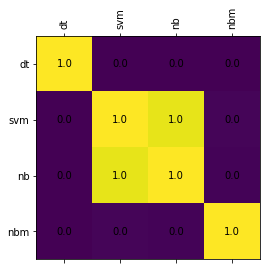

Scores: 
      Score 0  Score 1  Score 2   Score 3  Mean score
dt   0.639053     0.25     0.45  0.577236    0.479072
nb   0.869822     0.00     0.20  0.341463    0.352821
nbm  0.899408     0.00     0.05  0.422764    0.343043
svm  0.928994     0.00     0.00  0.243902    0.293224

Mean: 0.36704024751046327







In [11]:
for task in tasks:
    print(f'\nTask: {task.title()}\n')
    overall_evaluation(task, tasks[task]) #find the rankings for all models
    algorithm_and_rep_eval(task, tasks[task]) #group representations and algorithms together, evaluate